In [43]:
import os
import numpy as np
from struct import unpack
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 17}
plt.rc('font', **font_mapping)

In [49]:
def plot_volumes(volumes, title, legend=None):
    #
    plt.figure(figsize=(3, 4))
    
    x_min, x_max = 1000000, 0
    for index, volume_list in enumerate(volumes):
        ax = sns.histplot(data=volume_list, bins=60, alpha=1, kde=True, linewidth=0, color='#f0f0f0', edgecolor='#f0f0f0', stat='percent', line_kws=dict(color='blue', alpha=1, linewidth=1.0, label='KDE', linestyle='solid'))
        if index == 0:
            ax.get_lines()[-1].set_color('red') # edit line color due to bug in sns v 0.11.0
        elif index == 1:
            ax.get_lines()[-1].set_color('blue')  
        elif index == 2:
            ax.get_lines()[-1].set_color('green') 
            
        if x_min > min(volume_list):
            x_min = min(volume_list)
            
        if x_max < max(volume_list):
            x_max = max(volume_list)
            
    if len(volumes) > 1:
        plt.legend(legend, loc='upper right', fontsize=12, frameon=False)
            
    # remove right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # light gray background
    ax.set_facecolor('#f0f0f0')
    # put y label in the top left corner, non-rotated
    plt.text(-0.15, 1.095, 'Frequency', ha='left', va='top', transform=plt.gca().transAxes)
    plt.text(1.0, -0.025, 'Volume', ha='right', va='top', transform=plt.gca().transAxes)
    plt.xticks([])
    plt.xlim(x_min, x_max)
    plt.ylim(0, 8)
    plt.savefig('fragment_size_' + title + '.png', dpi=300, bbox_inches='tight')
    plt.show()

In [50]:
folder = '../../MeshFragments/Output/serapis/'
noise_dist_key = [['regular', 'nd'], ['bias_10', 'bias_5', 'bias_-56']]
noise_dist_key_title = ['Noise distribution', 'Biased uniform distribution']
noise_dist_legend = [['Uniform distribution', 'Normal distribution'], ['S = 5; 32 bias seeds', 'S = 10; 32 bias seeds', 'S = 10; 6 bias seeds']]

In [51]:
def read_rle(filename):
    # read binary file
    with open(filename, 'rb') as f:
        # read three unsigned integers
        width = int.from_bytes(f.read(4), byteorder='little')
        height = int.from_bytes(f.read(4), byteorder='little')
        depth = int.from_bytes(f.read(4), byteorder='little')
        grid = np.zeros(width * height * depth, dtype=np.uint8)

        # read until end of file
        offset = 0
        while True:
            binary_data = f.read(6)
            if not binary_data:
                break
            data = unpack('<HI', binary_data)
            rle_chunk = {'value': data[0], 'length': data[1]}
            grid[offset:offset + rle_chunk['length']] = rle_chunk['value']
            offset += rle_chunk['length']

        grid = grid.reshape((width, height, depth))     # to grid
        grid = np.flip(grid, 1)                    # only for our dataset
        max_dim = max(width, height, depth)             # pad to make it a square
        pad_width = [(0, max_dim - width), (0, max_dim - height), (0, max_dim - depth)]
        grid = np.pad(grid, pad_width, mode='constant', constant_values=0)
        
        return grid

Processing files with key: regular
Number of files: 10
Processing files with key: nd
Number of files: 10
Number of fragments: [100, 100]
Sum of fragment sizes: [6828460, 6828460]


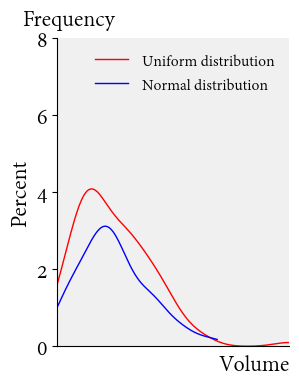

Processing files with key: bias_10
Number of files: 10
Processing files with key: bias_5
Number of files: 10
Processing files with key: bias_-56
Number of files: 10
Number of fragments: [139, 376, 130]
Sum of fragment sizes: [6828460, 6828460, 6828460]


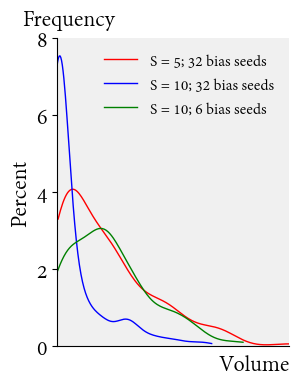

In [52]:
# Find files in folder starting with keys
glob_files = os.listdir(folder)

for index, keys in enumerate(noise_dist_key):
    volumes = []
    for key in keys:
        files = [f for f in glob_files if f.startswith(key) and f.endswith('.rle')]
            
        print('Processing files with key:', key)
        print('Number of files:', len(files))
        
        volumes.append([])
        
        for file in files:
            grid = read_rle(folder + file)
            distinct_values = np.unique(grid)
            n_distinct_values = len(distinct_values) - 1
                
            for fragment in distinct_values:
                if fragment > 1:
                    volumes[-1].append(np.sum(grid == fragment))
                    
    # sum number of fragments
    print('Number of fragments:', [len(volume) for volume in volumes])
    print('Sum of fragment sizes:', [sum(volume) for volume in volumes])
    
    # plot frequency of fragment sizes
    plot_volumes(volumes, noise_dist_key_title[index], legend=noise_dist_legend[index])